In [211]:
from glob import glob
import numpy as np 
import pandas as pd
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')

import argparse
import gc
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from thomas_detector import *

In [212]:
detector = ThomasDetector()


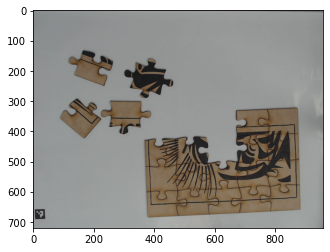

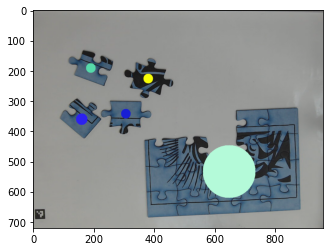

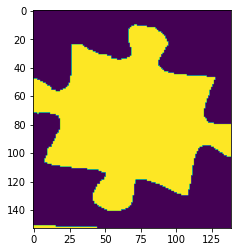

In [552]:
img1 = cv2.imread('small.jpg')
plt.imshow(img1[:, :, ::-1])
plt.show()
plt.imshow(detector.process(img1.copy())[0])
plt.show()
img_m1 = detector.pieces[1].img
plt.imshow(img_m1)
plt.show()

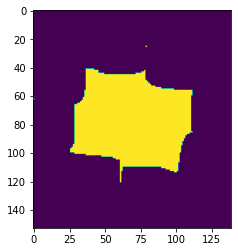

In [553]:
kernel = np.ones((20, 20), np.uint8)
plt.imshow(cv2.erode(img_m1, kernel) )

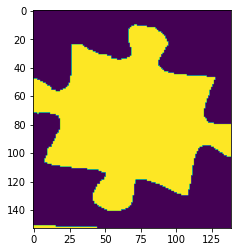

In [554]:
plt.imshow(img_m1)

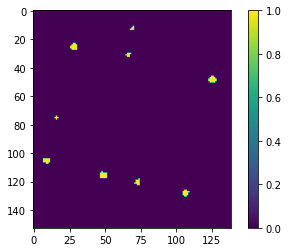

In [555]:
corner_vals = cv2.cornerHarris(img_m1,7,5,0.07) > 1
corners = []
for i in range(corner_vals.shape[0]):
    for j in range(corner_vals.shape[1]):
        if corner_vals[i, j] > 0:
            corners.append((j, i))
corners = np.array(corners)    
plt.imshow(corner_vals)
plt.colorbar()
# plt.scatter(corners[:, 1], corners[:, 0])
# pos = pca.inverse_transform(([0, 0], [0, 100]))
# plt.plot(pos[:, 0], pos[:, 1])

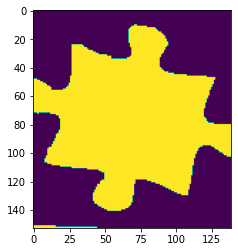

In [556]:
threshold = 100
# filtered = cv2.medianBlur(img_m1,41)
filtered = cv2.dilate(img_m1, np.ones((5, 5)))
kernel = np.ones((5, 5), np.uint8)
filtered = cv2.erode(filtered, kernel)
contours, hierarchy = cv2.findContours(filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.imshow(filtered)

In [557]:
biggest_contour = max(contours, key = cv2.contourArea).reshape(-1, 2)
derivatives = np.zeros_like(biggest_contour, dtype = np.float32)
centroid = np.mean(biggest_contour, axis = 0)
step = 2
for i in range(len(biggest_contour)):
    prev_point = biggest_contour[(i - step) % len(biggest_contour)]
    next_point = biggest_contour[(i + step) % len(biggest_contour) ]
    
    v = next_point - prev_point
    derivatives[i] = (-v[1], v[0])
    print(derivatives[i], derivatives[i]/ np.linalg.norm(derivatives[i]))
    derivatives[i] = derivatives[i] / (0.00001 + np.linalg.norm(derivatives[i]))

[ 0. -4.] [ 0. -1.]
[-2. -4.] [-0.4472136 -0.8944272]
[-3. -4.] [-0.6 -0.8]
[-3. -3.] [-0.7071068 -0.7071068]
[-4. -2.] [-0.8944272 -0.4472136]
[-4. -1.] [-0.97014254 -0.24253564]
[-4.  0.] [-1.  0.]
[-4.  0.] [-1.  0.]
[-4.  0.] [-1.  0.]
[-4.  0.] [-1.  0.]
[-4.  0.] [-1.  0.]
[-4.  0.] [-1.  0.]
[-4.  1.] [-0.97014254  0.24253564]
[-4.  1.] [-0.97014254  0.24253564]
[-4.  1.] [-0.97014254  0.24253564]
[-4.  2.] [-0.8944272  0.4472136]
[-4.  1.] [-0.97014254  0.24253564]
[-4.  1.] [-0.97014254  0.24253564]
[-4.  1.] [-0.97014254  0.24253564]
[-4.  0.] [-1.  0.]
[-4.  0.] [-1.  0.]
[-4. -1.] [-0.97014254 -0.24253564]
[-4. -2.] [-0.8944272 -0.4472136]
[-3. -3.] [-0.7071068 -0.7071068]
[-3. -4.] [-0.6 -0.8]
[-2. -4.] [-0.4472136 -0.8944272]
[-1. -4.] [-0.24253564 -0.97014254]
[-1. -4.] [-0.24253564 -0.97014254]
[ 0. -4.] [ 0. -1.]
[ 0. -4.] [ 0. -1.]
[ 0. -4.] [ 0. -1.]
[ 0. -4.] [ 0. -1.]
[ 0. -4.] [ 0. -1.]
[ 0. -4.] [ 0. -1.]
[ 0. -4.] [ 0. -1.]
[ 1. -4.] [ 0.24253564 -0.97014254]
[ 

In [558]:
def calc_rotation(biggest_contour, step = 2, n_thetas = 360):
    derivatives = np.zeros_like(biggest_contour, dtype = np.float32)
    
    for i in range(len(biggest_contour)):
        prev_point = biggest_contour[(i - step) % len(biggest_contour)]
        next_point = biggest_contour[(i + step) % len(biggest_contour) ]
        v = next_point - prev_point
        derivatives[i] = (-v[1], v[0])
        derivatives[i] = derivatives[i] / (0.00001 + np.linalg.norm(derivatives[i]))

    thetas = np.linspace(0, 2*np.pi, n_thetas)
    theta_sums = []
    for theta in thetas:
        rotation_vectors = np.array([[np.sin(theta), np.cos(theta)], 
                                     [np.cos(theta), -np.sin(theta)]])
        min_vec = 2*(np.min(np.square((derivatives @ rotation_vectors)), axis = 1))
        theta_sums.append(np.sum(min_vec))
    
    return thetas[np.argmin(theta_sums)]

In [559]:
calc_rotation(biggest_contour)

1.352022465124298

IndexError: index 532 is out of bounds for axis 0 with size 532

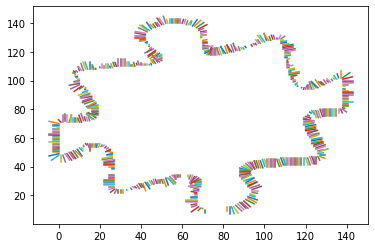

In [512]:
for i in range(0, len(biggest_contour), 1): 
    points = np.array((biggest_contour[i], biggest_contour[i] + 5*min_vec[i]*derivatives[i]))
    plt.plot(points[:, 0], points[:, 1])

In [ ]:
plt.figure(figsize = (10, 10))
plt.scatter(derivatives[:,0], derivatives[:,1], alpha = 0.2)

In [299]:
top_line_vector = box_raw[1] - box_raw[0]
top_line_vector = top_line_vector / np.linalg.norm(top_line_vector)
np.arccos(top_line_vector.dot(np.array([1, 0])))

0.9179496704777452

In [222]:
maxWidth = 30
maxHeight = 30
dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

# compute the perspective transform matrix and then apply it
M = cv2.getPerspectiveTransform(box.astype(np.float32), dst)
warped = cv2.warpPerspective(img_m1, M, (maxWidth, maxHeight))

top_horizon = warped[5]
bottom_horizon = warped[25]
left_verticle = warped[:,5]
right_verticle = warped[:,25]

In [ ]:
def piece_to_warp()

def get_clusters(line):
    high_pixels = np.array([i for i in range(len(line)) if line[i] > 128])
    clusters = []
    cluster = []
    for i in range(len(high_pixels)):
        if (i > 0) and (high_pixels[i] > high_pixels[i-1] + 1):

            clusters.append(np.array(cluster))
            cluster = []
        else:
            cluster.append(high_pixels[i])
    clusters.append(np.array(cluster))
    return clusters

def get_line_type(line):
    if (line[2:-2] > 128).mean() > 0.83:
        return 'flat'
    
    clusters = get_clusters(line)
    clusters = [c for c in clusters if len(c) > 2]
    if len(clusters) > 1:
        return 'inward'
    else:
        return 'outward'

In [ ]:
get_line_type(right_verticle)

In [ ]:
plt.imshow(warped)

In [ ]:
plt.imshow(top_horizon.reshape(1, -1))

In [ ]:
# last_pixel = 0
# clusters = []
# cluster = []
# for i, pixel in enumerate(left_verticle):
#     if (last_pixel < 128 and pixel > 128):
#         cluster.append(i)
#     if (last_pixel > 128 and pixel < 128):
#         clusters.append(cluster)
#         cluster = []
# #     if(pixel > 128):
# #         cluster.append(i)
# if len(cluster) > 0:
#     clusters.append(cluster)

In [93]:
clusters

[array([1, 2, 3, 4, 5, 6, 7]), array([15, 16, 17, 18, 19, 20, 21, 22])]